# Planning

1. Context:
    Electronic House is an e-commerce of computer products for houses and offices.

    The Design team developed a new way to complete a purchase using a credit card, without having to fill in all the card information manually.
    
    
2. Business problem:
    An experiment was done with the old page (manual filling - Group A) and the new page (automatic filling - Group B). After a few months of the experiment, we have to check which payment type is more efficient.  


# Experiment Design

1. Goal: Define if automatic filling bring more GMV (Gross Merchandise Value) than manual filling

    Group A: manual filling <br>
    Group B: automatic filling<br><br> 
    
2. Experiment hypothesis:

    H0: avg GMV A = avg GMV B <br>
    H1: avg GMV A <> avg GMV B

# 0.0 Imports

In [59]:
import warnings
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import pingouin          as pg

from scipy.stats       import shapiro
from scipy.stats       import mannwhitneyu
from matplotlib.pyplot import figure
from statsmodels.stats import api as sms
from scipy             import stats

In [2]:
warnings.filterwarnings("ignore")

# 0.1 Loading Data

In [3]:
df_raw = pd.read_csv('ab_testing.csv')
df_raw.head(2)

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I


In [4]:
# Data types

df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45883 entries, 0 to 45882
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   uid        45883 non-null  int64 
 1   country    45883 non-null  object
 2   gender     45883 non-null  object
 3   spent      45883 non-null  int64 
 4   purchases  45883 non-null  int64 
 5   date       45883 non-null  object
 6   group      45883 non-null  object
 7   device     45883 non-null  object
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


In [5]:
# Change data types

df['date'] = pd.to_datetime(df['date'])

In [6]:
# Check NA

df.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

In [7]:
# Check duplicates values - uid

total_rows = df.shape[0]
total_uid = df['uid'].drop_duplicates().shape[0]

print(f'Number of rows: {total_rows}\nNumber of unique customers: {total_uid}')

Number of rows: 45883
Number of unique customers: 45883


# 1.0 Descriptive analysis

In [8]:
# Group A and group B must be equally distributed across contry, gender and device to ensure samples are not unbalaced

df_a = df[df['group'] == 'GRP A']
df_b = df[df['group'] == 'GRP B']

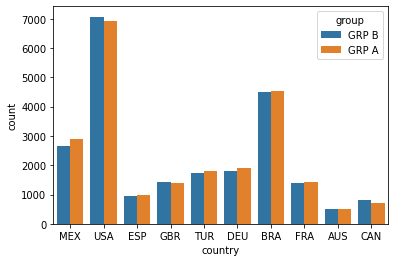

In [9]:
# Country

sns.countplot(df['country'], hue=df['group']);

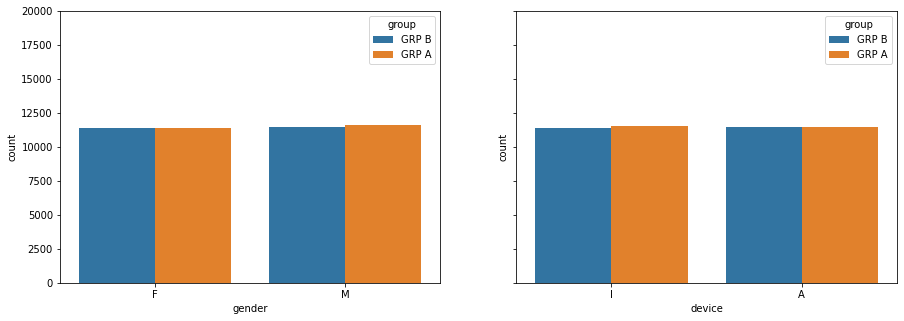

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.countplot(df['gender'], hue=df['group'], ax=ax[0])
sns.countplot(df['device'], hue=df['group'], ax=ax[1])
plt.ylim([0, 20000])
fig.show()

# 2.0 Experiment parameters

In [11]:
df1 = df.copy()

<AxesSubplot:xlabel='country', ylabel='spent'>

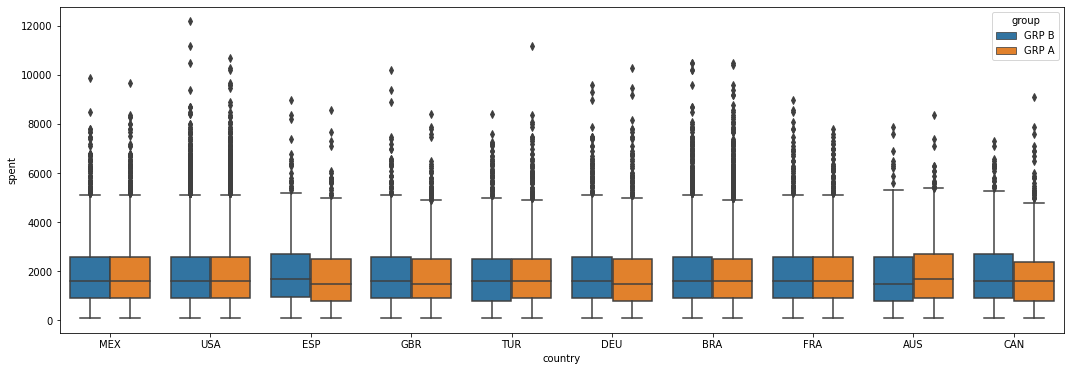

In [12]:
# As there are many countries, let's choose one of them to do the AB test

figure(figsize=(18,6))
sns.boxplot(x=df1['country'], y=df1['spent'], hue=df1['group'])

In [13]:
df2 = df1[df1['country'] == 'CAN']

## 2.1. Sample size

1. Determine the expected difference in success metrics
2. Calculate sample size

In [14]:
# Success metrics

df2_a = df2[df2['group'] == 'GRP A']
df2_b = df2[df2['group'] == 'GRP B']

spent_mean_a     = df2_a['spent'].mean()
spent_mean_b     = df2_b['spent'].mean()

print(f'Average spent by group A: {spent_mean_a:.2f}')
print(f'Average spent by group B: {spent_mean_b:.2f}')
print('\nExpected to increase 12% in average spent')

Average spent by group A: 1833.15
Average spent by group B: 1908.79

Expected to increase 12% in average spent


In [15]:
# Sample size

# 1. Effect size
# 2. Power
# 3. Confidence level

In [16]:
init_metric = spent_mean_a
end_metric = 1.12*init_metric
std_metric = np.std(df2['spent'])

effect_size = (end_metric - init_metric) / std_metric
print(f'Effect size: {effect_size:.4f}')

Effect size: 0.1634


In [46]:
sample_size = np.round(sms.tt_ind_solve_power(effect_size=effect_size, alpha=0.05, power=0.80),0)
print(f'Sample size: {sample_size}')
print(f'We need a sample of {sample_size:.0f} for group A and {sample_size:.0f} for group B.')

Sample size: 589.0
We need a sample of 589 for group A and 589 for group B.


In [18]:
# to identify a smaller variation between Group A and B, we would need more samples

In [19]:
df2['group'].value_counts()

GRP B    815
GRP A    698
Name: group, dtype: int64

## 2.2 Descriptive Statistics

In [20]:
total_rows = df2.shape[0]
total_columns = df2.shape[1]

print(f'Number of rows: {total_rows}\nNumber of colunms: {total_columns}')

Number of rows: 1513
Number of colunms: 8


In [21]:
# Check experimental unit (one user can not be in the other group)

df2[['uid', 'group']].groupby('uid').count().reset_index().query('group > 2')

,uid,group


In [22]:
# Gender homogenity

df2[['gender','group','uid']].groupby(['group','gender']).count()

uid
group gender     
GRP A F       347
      M       351
GRP B F       402
      M       413

In [23]:
# Device homogenity
df2[['device','group','uid']].groupby(['group','device']).count()

uid
group device     
GRP A A       337
      I       361
GRP B A       443
      I       372

In [31]:
df2.groupby('group').agg({'country':'count',
                         'spent':['min','max','mean','median','std']})

country spent                                        
        count   min   max         mean  median          std
group                                                      
GRP A     698    99  9079  1833.154728  1595.0  1357.700155
GRP B     815    99  7284  1908.786503  1597.0  1337.657600

<AxesSubplot:xlabel='spent', ylabel='Count'>

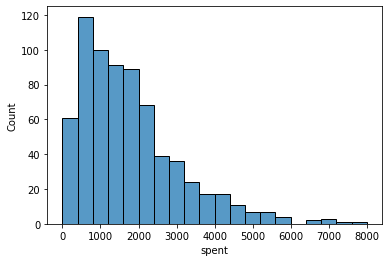

In [40]:
sns.histplot(df2_a['spent'], bins=20, binrange=[0, 8000])

<AxesSubplot:xlabel='spent', ylabel='Count'>

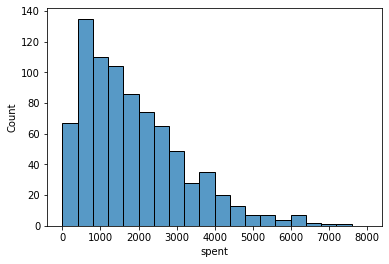

In [41]:
sns.histplot(df2_b['spent'], bins=20, binrange=[0, 8000])

# 3.0 Hypothesis tests

## 3.1 Groups

In [61]:
sample_size = sample_size.astype(int)

sample_A = df2_a['spent'].sample(n=sample_size, random_state=42)
sample_B = df2_b['spent'].sample(n=sample_size, random_state=42)

avg_spent_A = sample_A.mean()
avg_spent_B = sample_B.mean()

print(f'Average spent sample A: {avg_spent_A:.2f}')
print(f'Average spent sample B: {avg_spent_B:.2f}')

Average spent sample A: 1848.39
Average spent sample B: 1926.60


In [63]:
std_spent_A = sample_A.std()
std_spent_B = sample_B.std()

print(f'Std spent sample A: {std_spent_A:.2f}')
print(f'Std spent sample B: {std_spent_B:.2f}')

Std spent sample A: 1353.96
Std spent sample B: 1379.36


## 3.2 Statistical inference

In [25]:
# Continuous data
# Difference between averages
# Two groups
# Parametric assumption satisfied?
    # Yes: two-sample t-test
    # No: mann-whitney U

### 3.2.1. t-test

In [70]:
# Through the histograms we saw that the variable spent is not a normal distribution but let's apply ttest to see how it works

In [65]:
t_test, pvalue = stats.ttest_ind(sample_A, sample_B)
print(f'p-value: {pvalue:.4f}')

p-value: 0.3262


In [71]:
# H0: same averages
# if pvalue < 0.05:
   # H0 rejected
# else:
   # Failed in reject null hypothesis
    
# Conclusion: failed in reject null hypothesis
    # We can not affirm that the average between Group A and B are different

### 3.2.2. Mann-whitney U

In [66]:
# Parametric assumptions

# 1. Independent samples
# 2. Normal distribution
# 3. Equal variance

In [74]:
# 2. Normal distribution

# Shapiro test to check if it is a normal distribution
    # H0: normal distribuition
    # if pvalue < alpha: (alpha = 0.05)
        # Reject H0

alpha = 0.05

stats, pvalue = shapiro(df2['spent'])

if pvalue < alpha:
    print('The variable is NOT normally distributed')
else:
    print(f'The variable is NOT normally distributed')
    
print(f'\np-value: {pvalue}')

The variable is NOT normally distributed

p-value: 1.9761523292690557e-29


In [69]:
# 3. Equal variance

spent_var_a     = df2_a['spent'].var()
spent_var_b     = df2_b['spent'].var()

ratio_spent     = max(spent_var_a, spent_var_b)/min(spent_var_a, spent_var_b)

if ratio_spent < 4:
    print('Equal variance')
else:
    print('Not equal variance')
    
print(f'\nVariance rate of spent: {ratio_spent:.3f}')

Equal variance

Variance rate of spent: 1.030


In [73]:
# Mann-Whitney U-test

stats, pvalue_spent = mannwhitneyu(sample_A, sample_B)

#H0: average spent A = average spent B
# if p-value < alpha:
    # Reject H0
    
print(f'p-value: {pvalue_spent:.3f}')

p-value purchases: 0.395


In [75]:
# H0: same averages
# if pvalue < 0.05:
   # H0 rejected
# else:
   # Failed in reject null hypothesis
    
# Conclusion: failed in reject null hypothesis
    # We can not affirm that the average between Group A and B are different

# 4.0 Conclusion

We can not affirm that the average between Group A and B are different